In [2]:
%load_ext autoreload 
%matplotlib inline
%autoreload 2
import pathlib
import anndata as ad
import pandas as pd
import numpy as np
import json
import gzip
import shutil
import subprocess
from spatial_compare import SpatialCompare, spatial_detection_scores, compare_reference_and_spatial, summarize_and_plot 
from matplotlib import pyplot as plt
import seaborn as sns
from upsetplot import UpSet, generate_counts, from_contents, from_memberships
from matplotlib_set_diagrams import EulerDiagram

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# complete marmoset collection:

mad = ad.read_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/mFISH/brianl/marmoset_BG_atlas/intermediate_sections_HMBA_mapped.h5ad")

/allen/programs/celltypes/workgroups/hct/brianlong/conda/envs/sis-hpc/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
# marmoset rnaseq:
mref = ad.read_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/mFISH/brianl/marmoset_BG_atlas/mapping/prelim_HMBA_marmoset_xenium_genes.h5ad")

In [5]:
#adjust column names to match mapmycells results
mref.obs['HMBA_Macaque_Consensus-Group_label_Hierarchical_name'] = mref.obs['HMBA_Macaque_Consensus-Group_label_Hierarchical'].values

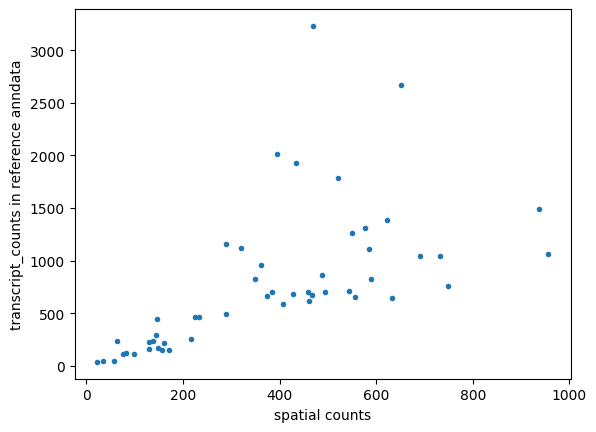

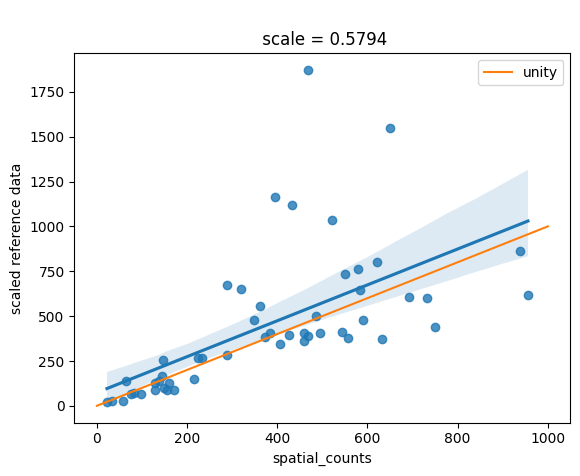

In [6]:

compare_reference_and_spatial(mref,mad, 
                                  category='HMBA_Macaque_Consensus-Group_label_Hierarchical_name', layer_field = None, 
                                  plot_stuff=True,
                                  target_obs_key = "transcript_counts", ok_to_clobber=True)


In [7]:
# loop over individual sections, comparing each to the whole dataset as reference
sds_against_all = {}
for ii,z in enumerate(sorted(list( mad.obs.filename.unique()))):

    s = spatial_detection_scores(mad.obs,mad[mad.obs.filename==z,:].obs, query_name=str(z), 
                                 category ='HMBA_Macaque_Consensus-Group_label_Hierarchical_name', n_bins=30, plot_stuff=False)
    sds_against_all[z]=s

/home/brianl/projects/spatial_compare/spatial_compare.py:658: RuntimeWarning: divide by zero encountered in log10
  s2.loc[s2[category]==c,["log_10_detection_ratio"]]=  np.log10((s2.loc[s2[category]==c,[comparison_column]] / means[c]).values)
/home/brianl/projects/spatial_compare/spatial_compare.py:658: RuntimeWarning: divide by zero encountered in log10
  s2.loc[s2[category]==c,["log_10_detection_ratio"]]=  np.log10((s2.loc[s2[category]==c,[comparison_column]] / means[c]).values)
/home/brianl/projects/spatial_compare/spatial_compare.py:658: RuntimeWarning: divide by zero encountered in log10
  s2.loc[s2[category]==c,["log_10_detection_ratio"]]=  np.log10((s2.loc[s2[category]==c,[comparison_column]] / means[c]).values)
/home/brianl/projects/spatial_compare/spatial_compare.py:658: RuntimeWarning: divide by zero encountered in log10
  s2.loc[s2[category]==c,["log_10_detection_ratio"]]=  np.log10((s2.loc[s2[category]==c,[comparison_column]] / means[c]).values)
/home/brianl/projects/spatia

In [8]:
# loop over individual sections, comparing each to the RNASeq dataset as reference
sds_against_rnaseq = {}
for ii,z in enumerate(sorted(list( mad.obs.filename.unique()))):

    s = spatial_detection_scores(mref.obs,mad[mad.obs.filename==z,:].obs, query_name=str(z), 
                                 category ='HMBA_Macaque_Consensus-Group_label_Hierarchical_name', n_bins=30, plot_stuff=False)
    sds_against_rnaseq[z]=s

/home/brianl/projects/spatial_compare/spatial_compare.py:658: RuntimeWarning: divide by zero encountered in log10
  s2.loc[s2[category]==c,["log_10_detection_ratio"]]=  np.log10((s2.loc[s2[category]==c,[comparison_column]] / means[c]).values)
/home/brianl/projects/spatial_compare/spatial_compare.py:658: RuntimeWarning: divide by zero encountered in log10
  s2.loc[s2[category]==c,["log_10_detection_ratio"]]=  np.log10((s2.loc[s2[category]==c,[comparison_column]] / means[c]).values)
/home/brianl/projects/spatial_compare/spatial_compare.py:658: RuntimeWarning: divide by zero encountered in log10
  s2.loc[s2[category]==c,["log_10_detection_ratio"]]=  np.log10((s2.loc[s2[category]==c,[comparison_column]] / means[c]).values)
/home/brianl/projects/spatial_compare/spatial_compare.py:658: RuntimeWarning: divide by zero encountered in log10
  s2.loc[s2[category]==c,["log_10_detection_ratio"]]=  np.log10((s2.loc[s2[category]==c,[comparison_column]] / means[c]).values)
/home/brianl/projects/spatia

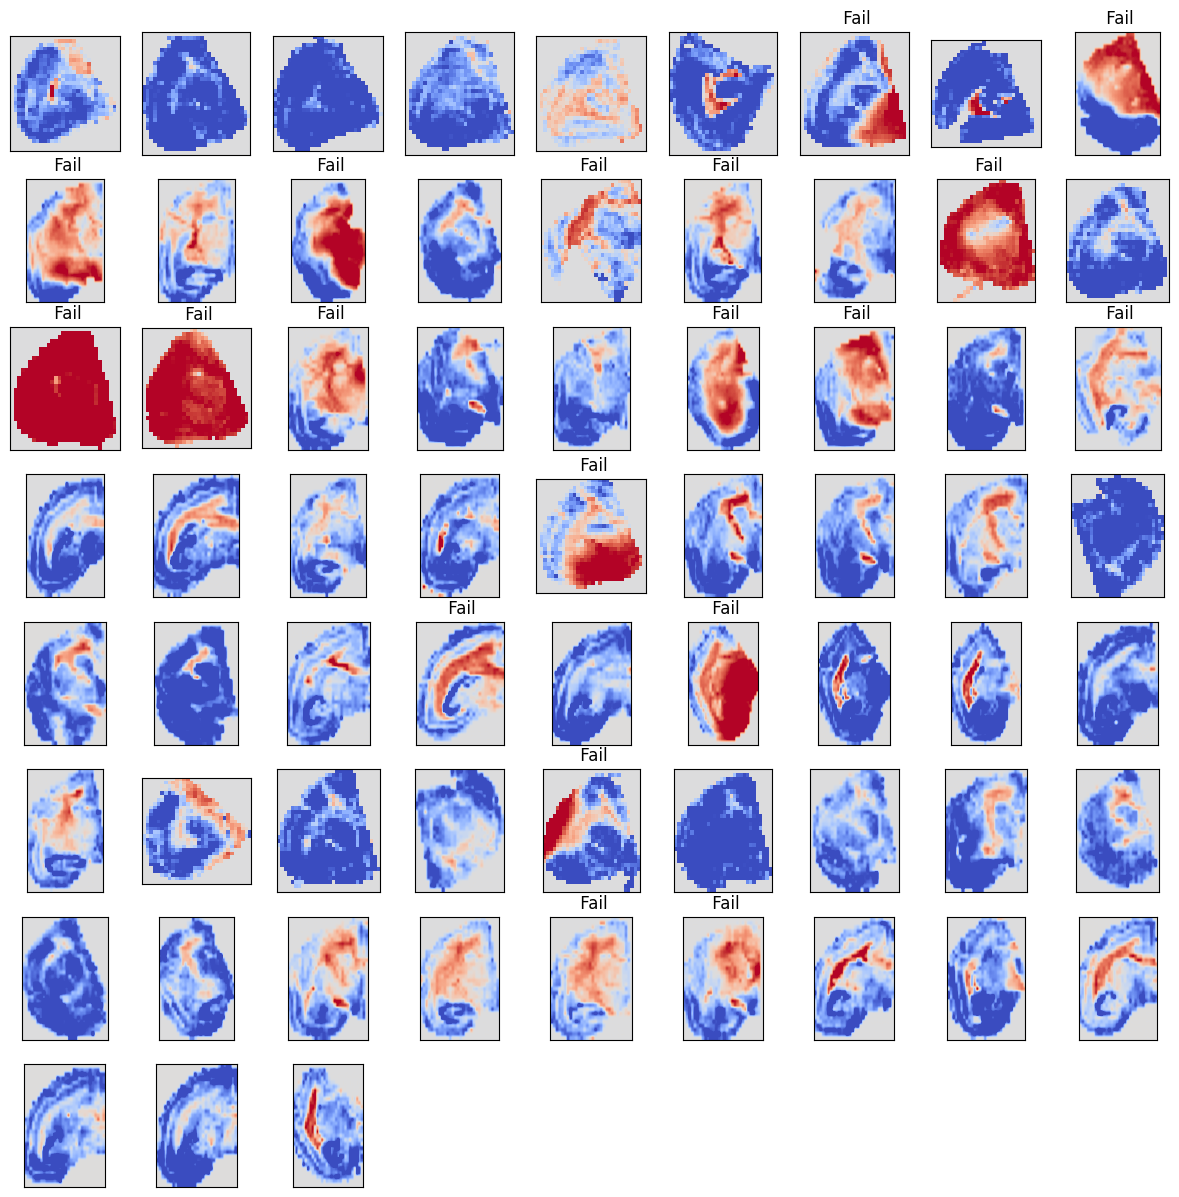

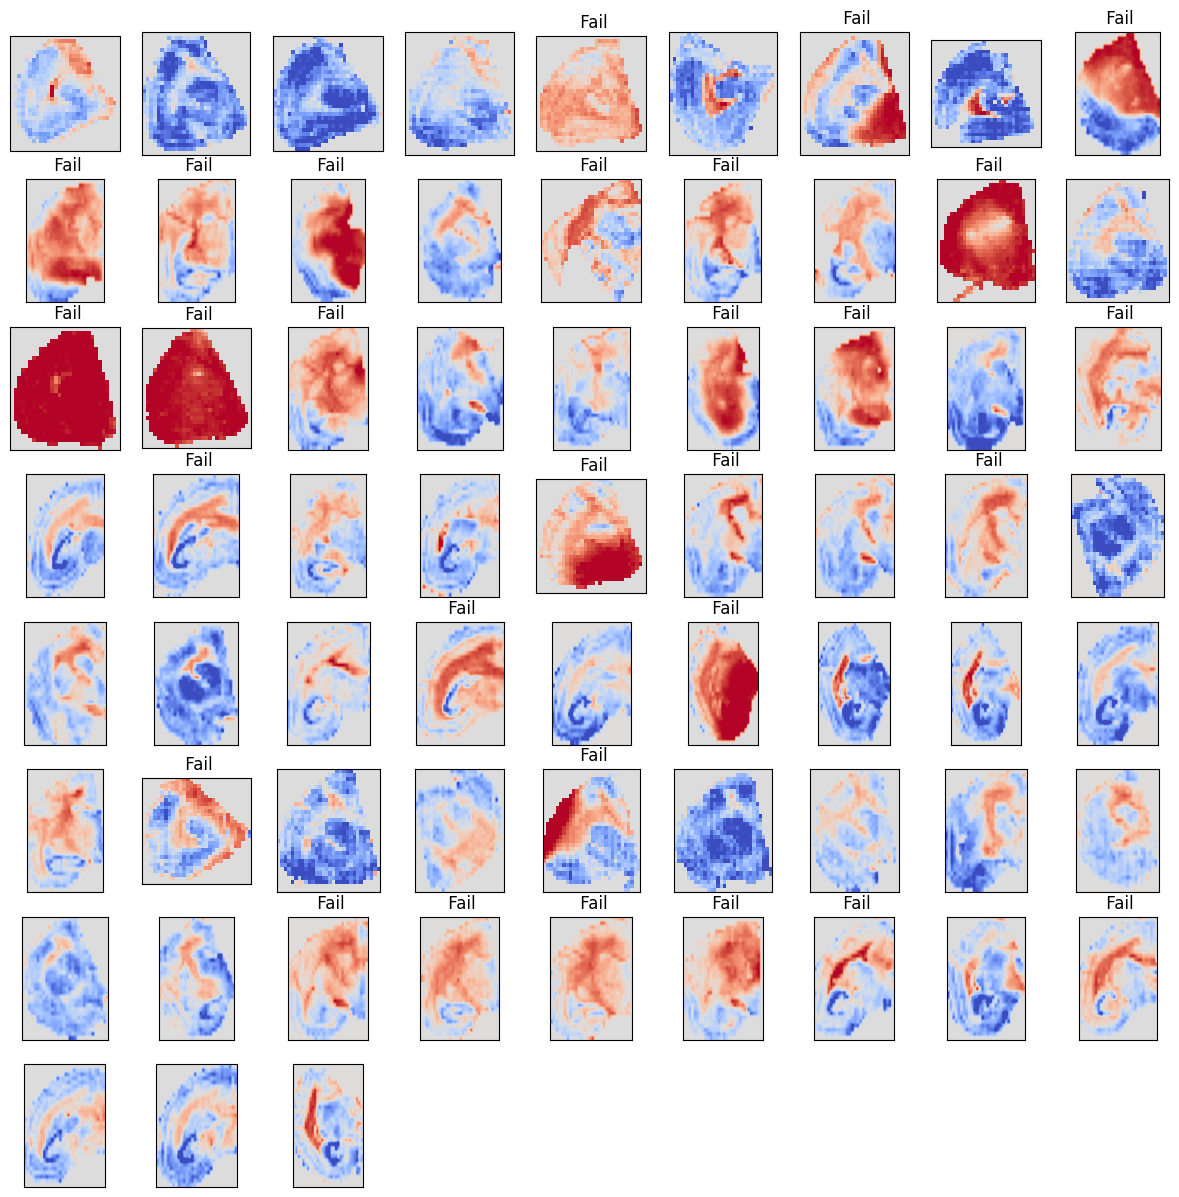

In [9]:
results_rnaseq=summarize_and_plot(sds_against_rnaseq)
results_spatial=summarize_and_plot(sds_against_all)

In [23]:
fails_vs_all = [r["key"] for r in results_spatial if r["failed"]]
fails_vs_rnaseq = [r["key"] for r in results_rnaseq if r["failed"]]

# make a dataframe for detailed QC per run
summary_df = pd.DataFrame(mad.obs.filename.unique(), columns=["filename"])
summary_df["spatial_compare_to_rnaseq_fail"] = [f in fails_vs_rnaseq for f in summary_df.filename]
summary_df["spatial_compare_to_spatial_fail"] = [f in fails_vs_all for f in summary_df.filename]
summary_df["section_name"] = [mad.obs.loc[mad.obs.xenium_filename==name,["section_name"]].values[0][0] for name in summary_df.filename]
summary_df["unique_acquisition_date"] = [mad.obs.loc[mad.obs.xenium_filename==name,["unique_acquisition_date"]].values[0][0] for name in summary_df.filename]

summary_df.sort_values("section_name", ignore_index=True, inplace=True)
wdr_fails=["CJ23.56.004.CX.42.09.06","CJ23.56.004.CX.42.11.06","CJ23.56.004.CX.42.11.07","CJ23.56.004.CX.42.12.07",
           "CJ23.56.004.CX.42.12.06","CJ23.56.004.CX.42.21.07","CJ23.56.004.CX.43.02.07","CJ23.56.004.CX.43.03.06",
           "CJ23.56.004.CX.43.04.07","CJ23.56.004.CX.43.05.06","CJ23.56.004.CX.43.09.06"]
redos=["CJ23.56.004.CX.42.09.07","CJ23.56.004.CX.42.11.07","CJ23.56.004.CX.42.12.06","CJ23.56.004.CX.43.04.06",
       "CJ23.56.004.CX.43.05.07","CJ23.56.004.CX.44.07.07","CJ23.56.004.CX.44.08.07","CJ23.56.004.CX.44.11.07","CJ23.56.004.CX.44.12.06"]
         


summary_df["WDR_fail"] = [f in wdr_fails for f in summary_df.section_name]
summary_df["is_redo"] = [f in redos for f in summary_df.section_name]


In [17]:
summary_df.to_csv("/allen/programs/celltypes/workgroups/rnaseqanalysis/mFISH/brianl/marmoset_BG_atlas/intermediate_sections_HMBA_mapped_QC_info.csv")

In [ ]:
mad.obs = pd.merge(mad.obs,summary_df.loc[:, ["spatial_compare_to_rnaseq_fail", 	"spatial_compare_to_spatial_fail", 	"section_name" , 	'WDR_fail' ,	'is_redo']], on = "section_name")


In [ ]:
mad.write_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/mFISH/brianl/marmoset_BG_atlas/intermediate_sections_HMBA_mapped_QC_obs.h5ad")

In [26]:
memberships = [[col for col in ['spatial_compare_to_rnaseq_fail',
       'spatial_compare_to_spatial_fail', 'WDR_fail'] if summary_df.loc[summary_df.section_name==a,[col]].values.all()] for a in summary_df.section_name]

us = UpSet(from_memberships(memberships), subset_size='count')

us

for_euler = {a:us.intersections[a] for a in us.intersections.index}


us.intersections

for_euler

summary_df.loc[:,['spatial_compare_to_rnaseq_fail',
       'spatial_compare_to_spatial_fail', 'WDR_fail']].sum(axis=0)

for_euler_int = {}
# this implementation of Euler diagrams doesn't include non-intersecting categories. 
# so things that pass all QC categories (first column in upset plot) don't actually 
for key in for_euler.keys():
    if np.sum(key)==0:
        continue
    for_euler_int[tuple([int(b) for b in key])] = for_euler[key]


/allen/programs/celltypes/workgroups/hct/brianlong/conda/envs/sis-hpc/lib/python3.10/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)


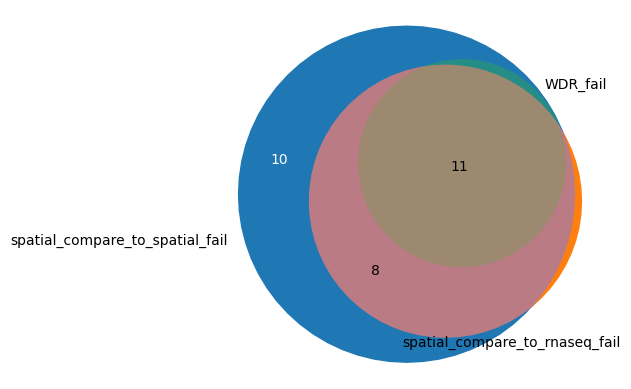

In [27]:
EulerDiagram(for_euler_int, set_labels = list(us.totals.keys()))

In [28]:
# complete sea-ad collection:

adad = ad.read_h5ad("/allen/programs/celltypes/workgroups/hct/emilyg/mapping/202407_xenium/final_gene_panel_mapping/mtg_mapping/COMBO_2024-10-29_52sects_mtg_and_pfc_mapping_and_gaston.h5ad")

/allen/programs/celltypes/workgroups/hct/brianlong/conda/envs/sis-hpc/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [29]:
adad.obs["x_centroid"]=adad.obsm["spatial_cirro"][:,0]
adad.obs["y_centroid"]=adad.obsm["spatial_cirro"][:,1]


In [6]:
adad.var.to_csv("/allen/programs/celltypes/workgroups/hct/SEA-AD/MERSCOPE/Xenium_Validation/DLPFC_2_var.csv")

In [251]:
adad.obs.barcode

0          1397628209
1          1397628209
2          1397628209
3          1397628209
4          1397628209
              ...    
3992856    1376583032
3992857    1376583032
3992858    1376583032
3992859    1376583032
3992860    1376583032
Name: barcode, Length: 3992861, dtype: category
Categories (52, object): ['1376583032', '1376583035', '1376584190', '1376584193', ..., '1397627946', '1397627949', '1397628206', '1397628209']

In [3]:
# subsetted the RNASeq reference thusly:
#adrna = ad.read_h5ad("/allen/programs/celltypes/workgroups/hct/SEA-AD/Multiregion/SEAAD_MTG_RNAseq_final-nuclei.2024-02-13.h5ad")
#dlpfc_var = pd.read_csv("/allen/programs/celltypes/workgroups/hct/SEA-AD/MERSCOPE/Xenium_Validation/DLPFC_2_var.csv",index_col=0)
# xgenes = list(dlpfc_var.index)
# mtg_ref = adrna[:,xgenes]
# mtg_ref.write_h5ad("/allen/programs/celltypes/workgroups/hct/SEA-AD/MERSCOPE/Xenium_Validation/MTG_RNASeq_Xenium_panel2_genes.h5ad")

In [30]:
mtg_ref= ad.read_h5ad("/allen/programs/celltypes/workgroups/hct/SEA-AD/MERSCOPE/Xenium_Validation/MTG_RNASeq_Xenium_panel2_genes.h5ad")

In [31]:
mtg_ref.obs["MTG_subclass_name"] = mtg_ref.obs["Subclass"].values

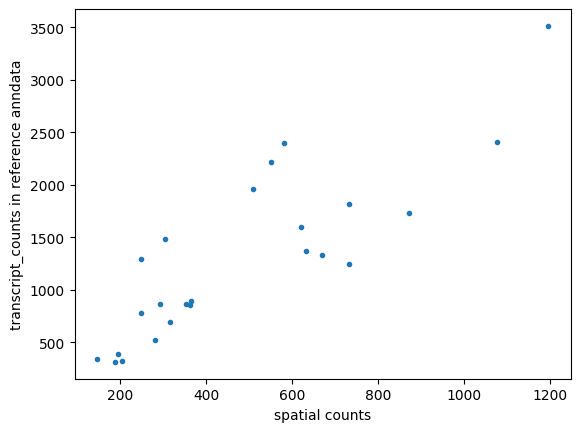

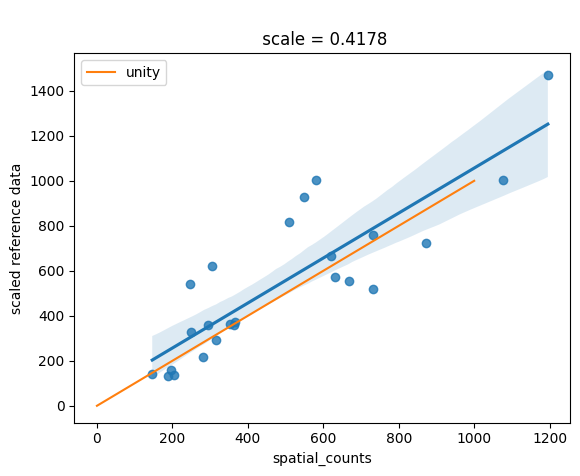

In [32]:
compare_reference_and_spatial(mtg_ref,adad, 
                                  category="MTG_subclass_name", layer_field = "UMIs", 
                                  plot_stuff=True,
                                  target_obs_key = "transcript_counts", ok_to_clobber=True)


In [33]:
# loop over individual sections, comparing each to the whole dataset as reference
ad_against_spatial = {}
for ii,z in enumerate(sorted(list( adad.obs.filename.unique()))):

    s = spatial_detection_scores(adad.obs,adad[adad.obs.filename==z,:].obs, query_name=str(z), 
                                 category ='subclass_name', n_bins=30, plot_stuff=False)
    ad_against_spatial[z]=s

In [34]:
# loop over individual sections, comparing each to the RNASeq  dataset as reference
ad_against_rna = {}
for ii,z in enumerate(sorted(list( adad.obs.filename.unique()))):

    s = spatial_detection_scores(mtg_ref.obs,adad.obs.loc[adad.obs.filename==z,:], query_name=str(z),
                                 category ='MTG_subclass_name', n_bins=30, in_place= False, plot_stuff = False)
    ad_against_rna[z]=s




In [35]:
# make a dataframe for detailed QC per run
ad_res_rnaseq =summarize_and_plot(ad_against_rna, plot_stuff=False)
ad_res_spatial =summarize_and_plot(ad_against_spatial, plot_stuff=False)

ad_fails_vs_rnaseq = [a["key"] for a in ad_res_rnaseq if a["failed"]]
ad_fails_vs_all = [a["key"] for a in ad_res_spatial if a["failed"]]
ad_fails_outright = [ "1394067467", "1376583035", "1397625705", "1397625702"]
ad_fails_requires_mask = ["1397627946", "1394071405", "1397628209", "1394071402",
                          "1394066176", "1394068583", "1394067858", "1394066589", 
                          "1394065584", "1397627727", "1397627830", "1397627825", 
                          "1394067472", "1394067096", "1388473577", "1379033437"]


ad_summary_df = pd.DataFrame(adad.obs.filename.unique(), columns=["filename"])
ad_summary_df["barcode"] = [adad.obs.loc[adad.obs.filename==name,["barcode"]].values[0][0] for name in ad_summary_df.filename]
ad_summary_df["qc_review_fail"] = [f in ad_fails_outright for f in ad_summary_df.barcode]
ad_summary_df["qc_review_mask_required"] = [f in ad_fails_requires_mask for f in ad_summary_df.barcode]
ad_summary_df["spatial_compare_to_rnaseq_fail"] = [f in ad_fails_vs_rnaseq for f in ad_summary_df.filename]
ad_summary_df["spatial_compare_to_spatial_fail"] = [f in ad_fails_vs_all for f in ad_summary_df.filename]
ad_summary_df["section_name"] = [adad.obs.loc[adad.obs.filename==name,["specimen_ID"]].values[0][0] for name in ad_summary_df.filename]


ad_summary_df.sort_values("section_name", ignore_index=True, inplace=True)    


# generate pieces needed for upset plot and Euler diagram

memberships = [[col for col in ['spatial_compare_to_rnaseq_fail',
                               'spatial_compare_to_spatial_fail',
                                "qc_review_mask_required","qc_review_fail"] if ad_summary_df.loc[summary_df.section_name==a,[col]].values.all()] for a in summary_df.section_name]

us = UpSet(from_memberships(memberships), subset_size='count')

us

for_euler = {a:us.intersections[a] for a in us.intersections.index}

/allen/programs/celltypes/workgroups/hct/brianlong/conda/envs/sis-hpc/lib/python3.10/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)


In [47]:
us.intersections

spatial_compare_to_spatial_fail  spatial_compare_to_rnaseq_fail  qc_review_mask_required  qc_review_fail
False                            False                           False                    False             18
True                             False                           False                    False              4
False                            False                           True                     False              9
                                                                 False                    True               1
True                             True                            False                    False             10
                                 False                           False                    True               1
                                 True                            True                     False              7
                                                                 False                    True               2
       

In [46]:
for_euler

{(False, False, False, False): 18,
 (True, False, False, False): 4,
 (False, False, True, False): 9,
 (False, False, False, True): 1,
 (True, True, False, False): 10,
 (True, False, False, True): 1,
 (True, True, True, False): 7,
 (True, True, False, True): 2,
 (True, True, True, True): 14}

In [36]:
for_euler_int = {}
# this implementation of Euler diagrams doesn't include non-intersecting categories. 
# so things that pass all QC categories (first column in upset plot) don't actually 
for key in for_euler.keys():
    if np.sum(key)==0:
        continue
    for_euler_int[tuple([int(b) for b in key])] = for_euler[key]

/allen/programs/celltypes/workgroups/hct/brianlong/conda/envs/sis-hpc/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/allen/programs/celltypes/workgroups/hct/brianlong/conda/envs/sis-hpc/lib/python3.10/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method 

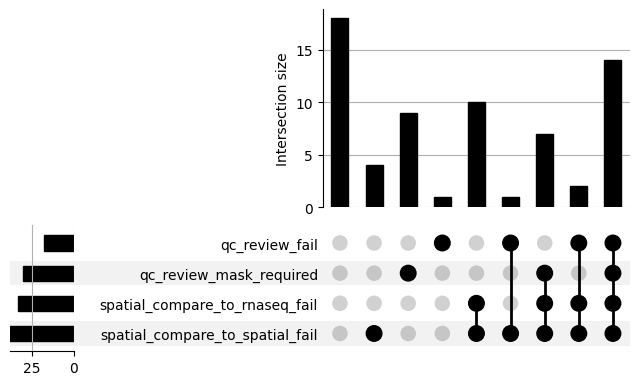

In [262]:
us

In [48]:
for_euler_int

{(1, 0, 0, 0): 4,
 (0, 0, 1, 0): 9,
 (0, 0, 0, 1): 1,
 (1, 1, 0, 0): 10,
 (1, 0, 0, 1): 1,
 (1, 1, 1, 0): 7,
 (1, 1, 0, 1): 2,
 (1, 1, 1, 1): 14}

In [49]:
list(us.totals.keys())

['spatial_compare_to_spatial_fail',
 'spatial_compare_to_rnaseq_fail',
 'qc_review_mask_required',
 'qc_review_fail']

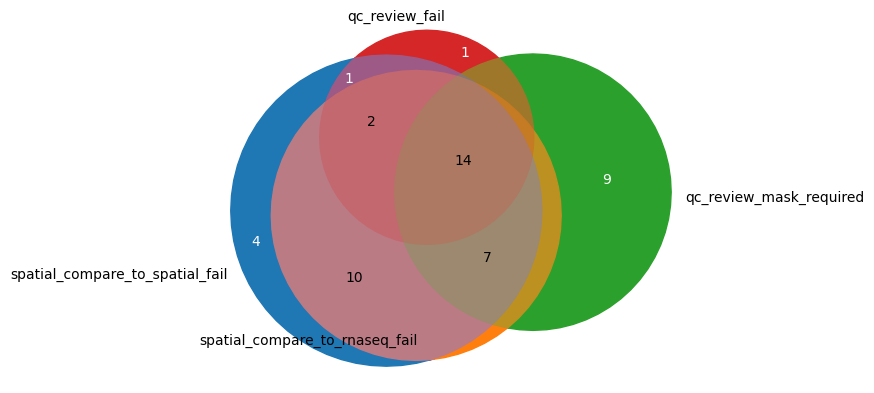

In [37]:
for_euler_int

EulerDiagram(for_euler_int, set_labels = list(us.totals.keys()))

In [50]:
summary_df.loc[:,["spatial_compare_to_rnaseq_fail", 	"spatial_compare_to_spatial_fail"]].sum(axis=0)

spatial_compare_to_rnaseq_fail     19
spatial_compare_to_spatial_fail    29
dtype: int64

In [53]:
ad_summary_df.loc[:,["spatial_compare_to_rnaseq_fail", 	"spatial_compare_to_spatial_fail",'qc_review_fail', 'qc_review_mask_required']].sum(axis=0)

spatial_compare_to_rnaseq_fail     19
spatial_compare_to_spatial_fail    24
qc_review_fail                      4
qc_review_mask_required            16
dtype: int64

In [52]:
ad_summary_df.columns

Index(['filename', 'barcode', 'qc_review_fail', 'qc_review_mask_required',
       'spatial_compare_to_rnaseq_fail', 'spatial_compare_to_spatial_fail',
       'section_name'],
      dtype='object')

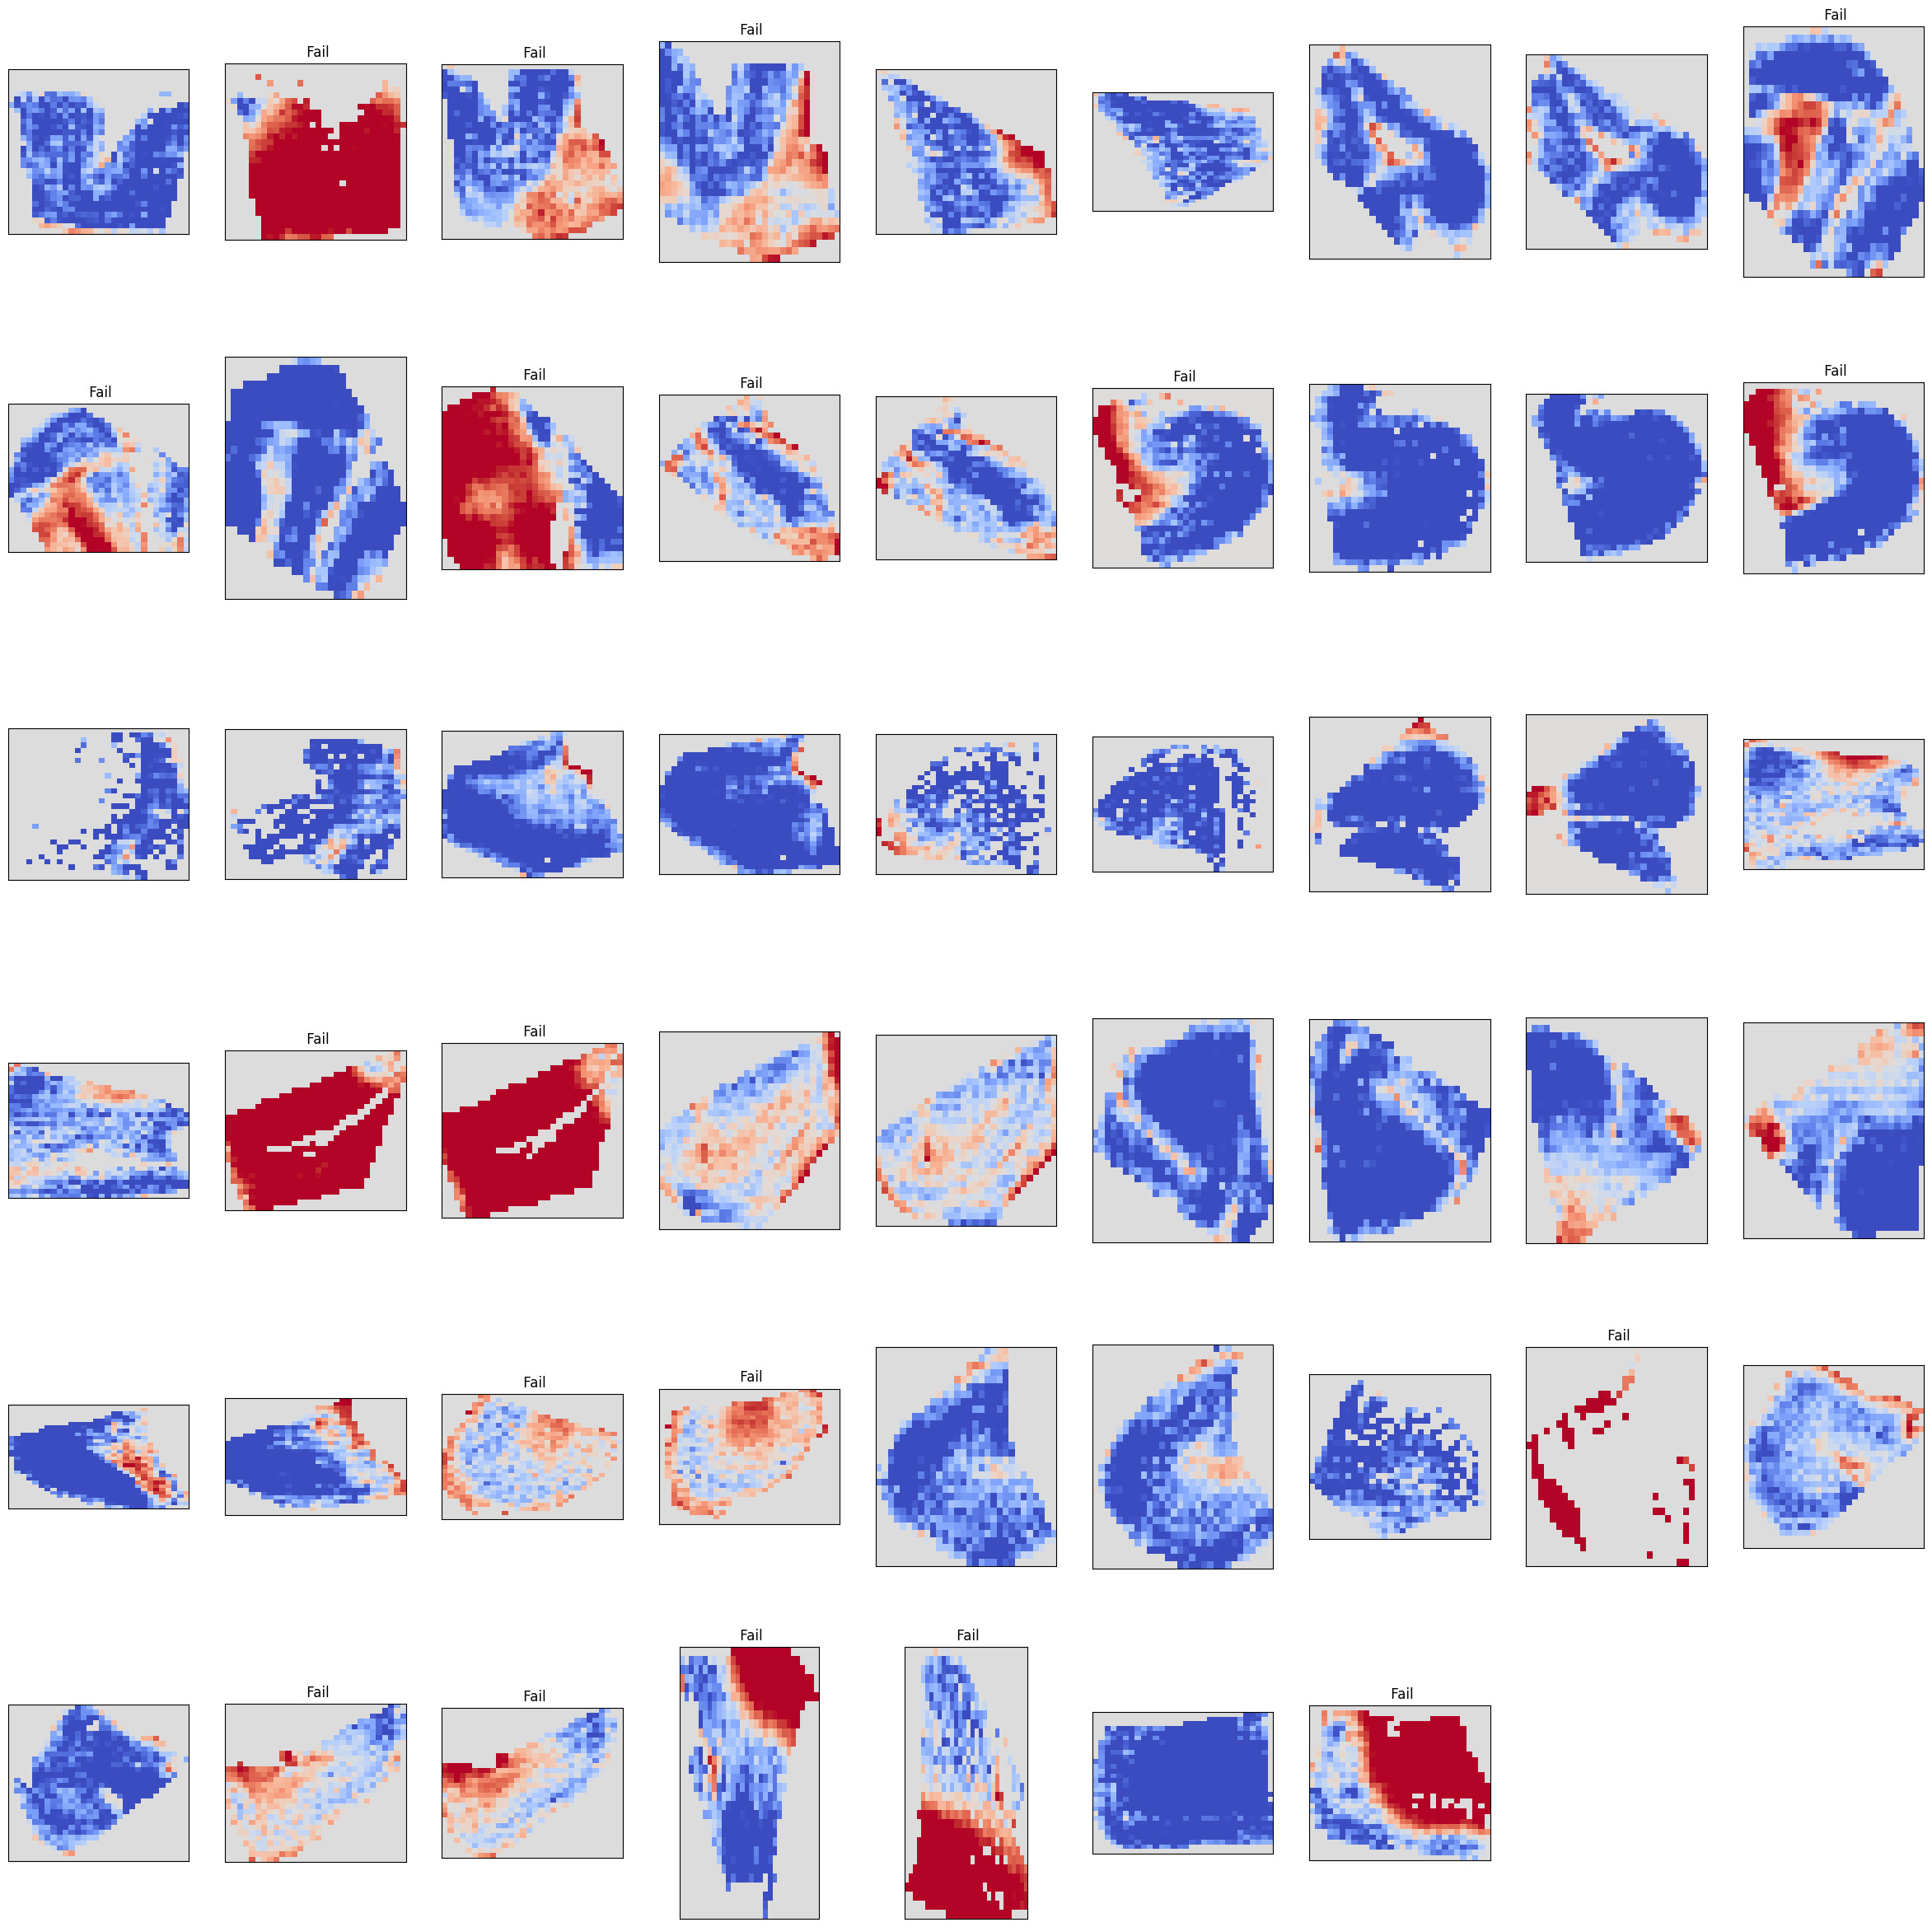

In [42]:
title_mapping = {key:ad_summary_df.loc[ad_summary_df.filename==key,:].barcode.values[0] 
                 for key in ad_against_rna.keys() if key in list(ad_summary_df.filename)}
a=summarize_and_plot(ad_against_rna,  figsize=[30,30])

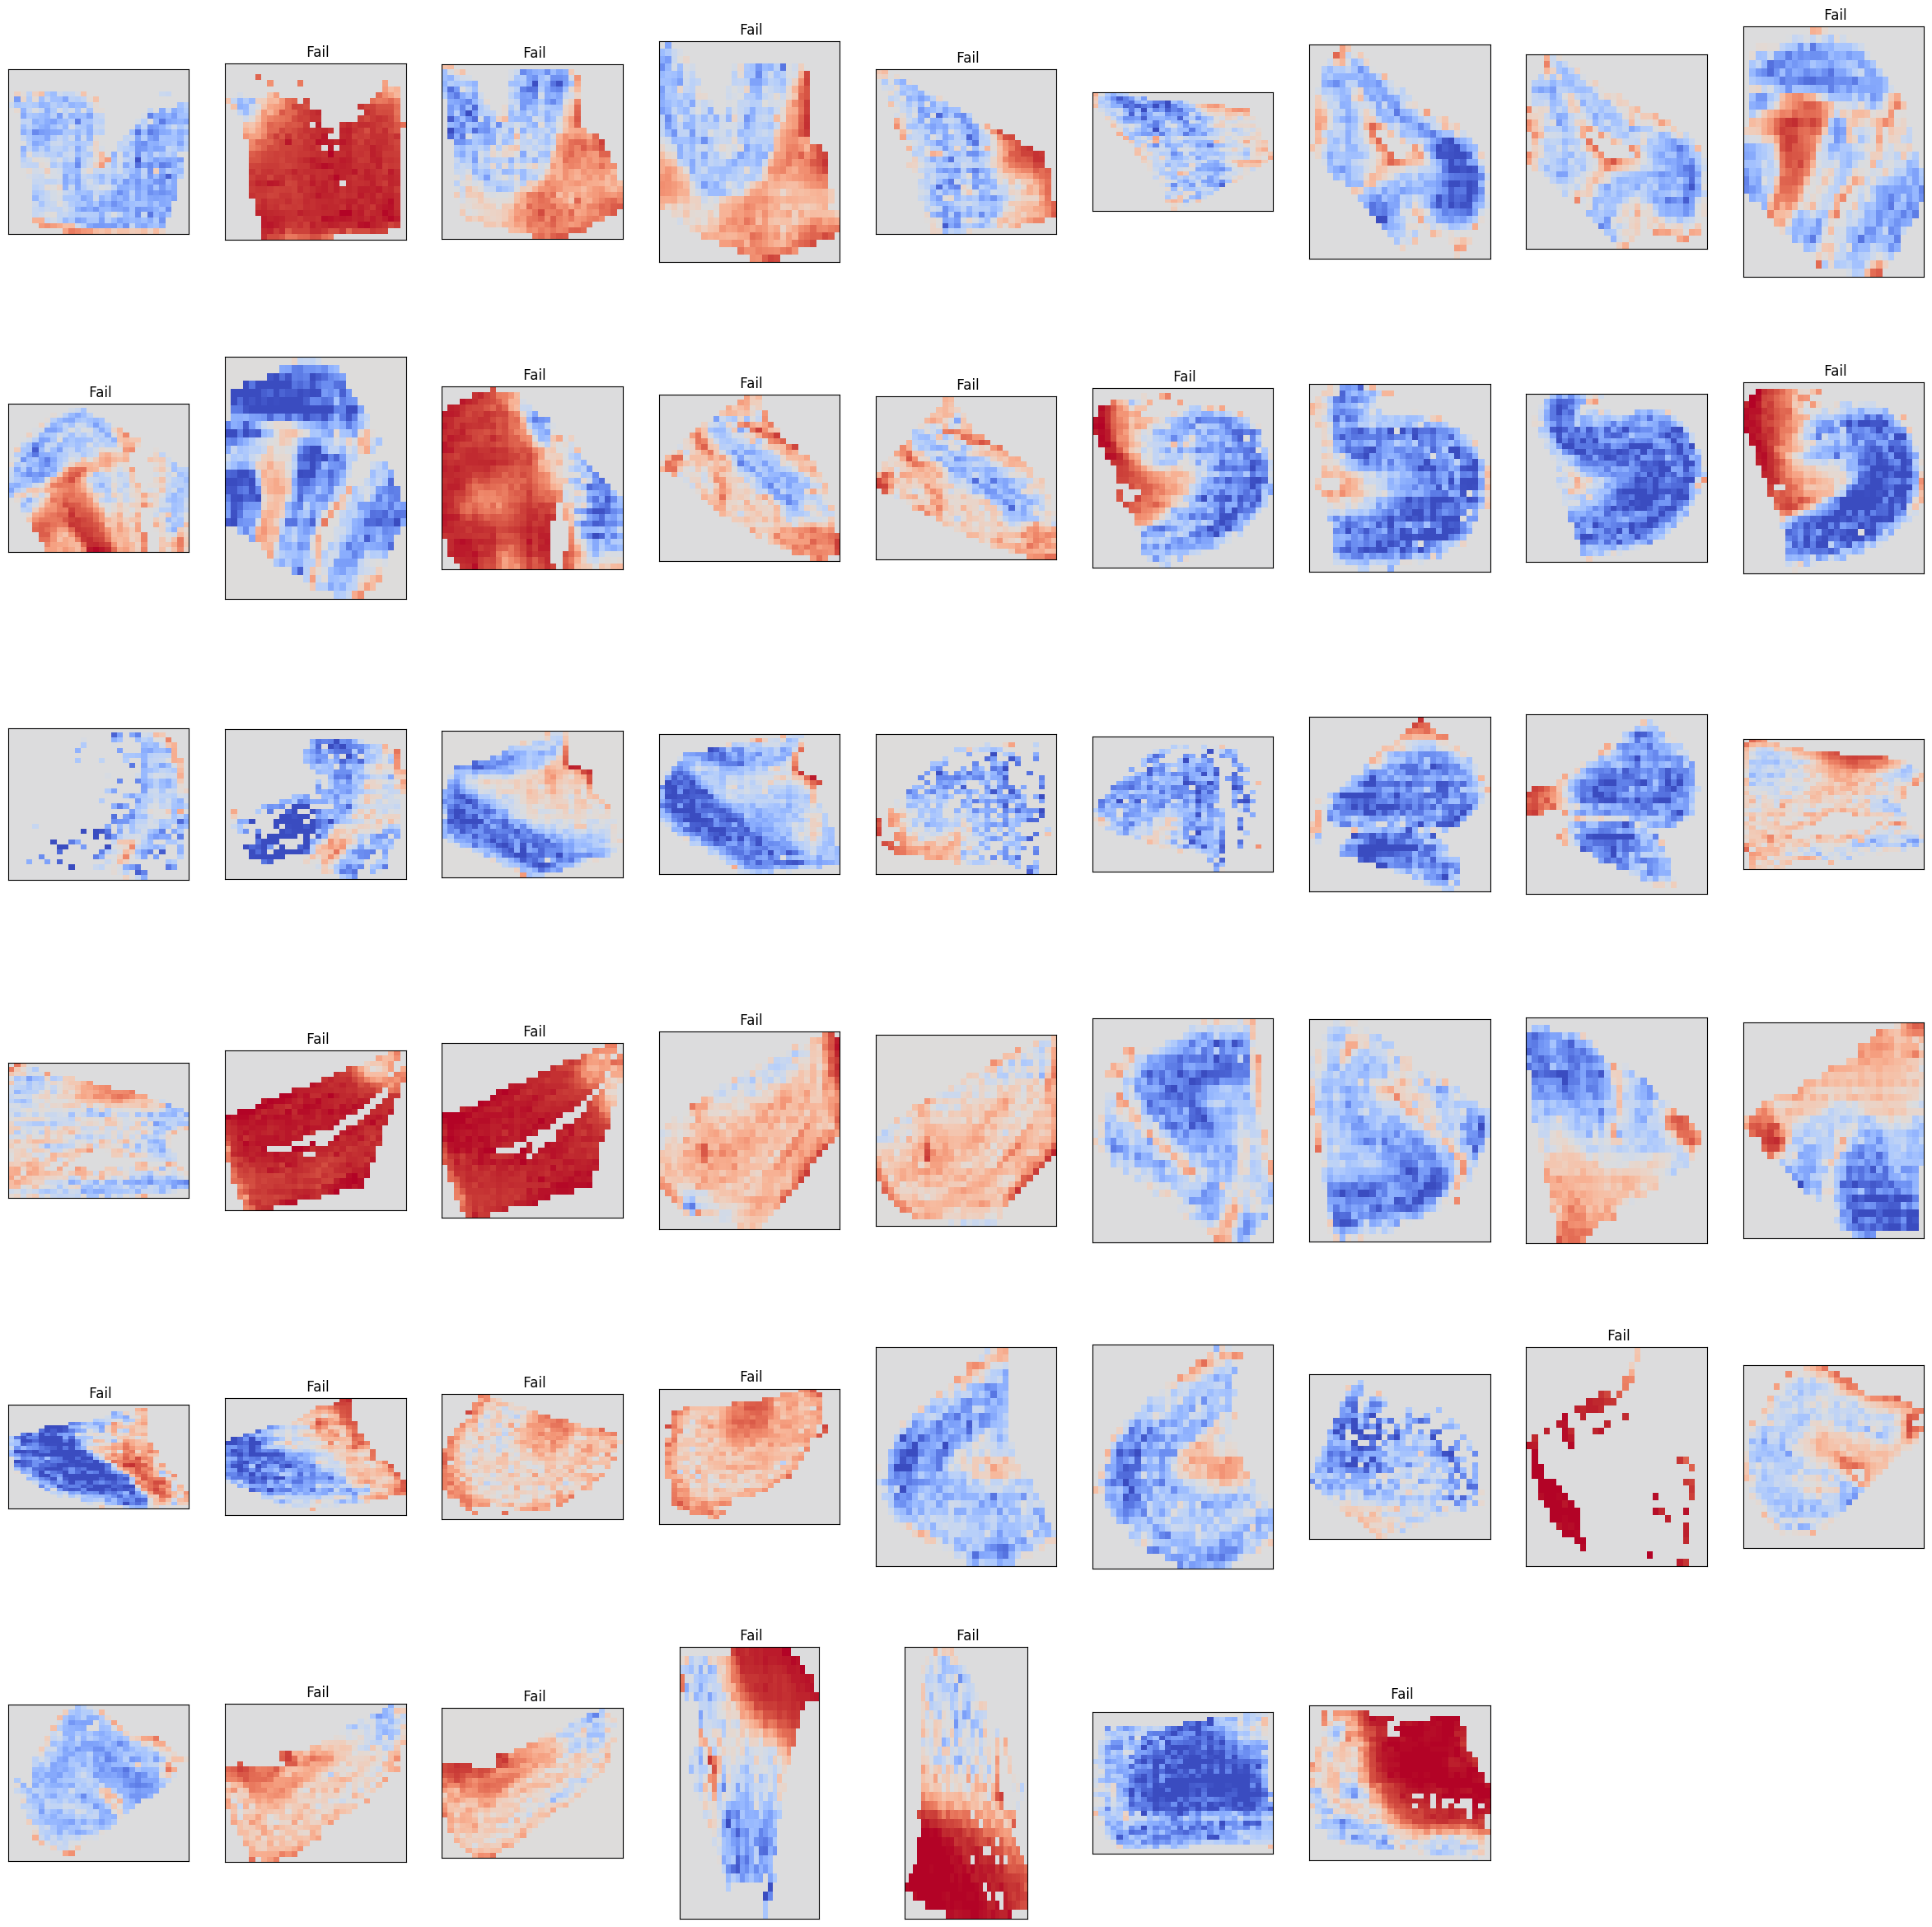

In [41]:
a=summarize_and_plot(ad_against_spatial, figsize=[30,30])

# analyze macaque MERSCOPE data

In [12]:

mac_ad = ad.read_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/NHP_spatial/For_Cirro/macaque_HMBA_BG_QM23.50.001.h5ad")

In [13]:
mac_ad.obs["x_centroid"]=mac_ad.obs.center_x
mac_ad.obs["y_centroid"]=mac_ad.obs.center_y

In [14]:
# loop over individual sections, comparing each to the whole dataset as reference
mac_against_spatial = {}
for ii,z in enumerate(sorted(list( mac_ad.obs.barcode.unique()))):

    s = spatial_detection_scores(mac_ad.obs,mac_ad[mac_ad.obs.barcode==z,:].obs, query_name=str(z), 
                                 category ='Subclass_Corr', n_bins=30, plot_stuff=False, comparison_column="n_transcripts")
    mac_against_spatial[z]=s

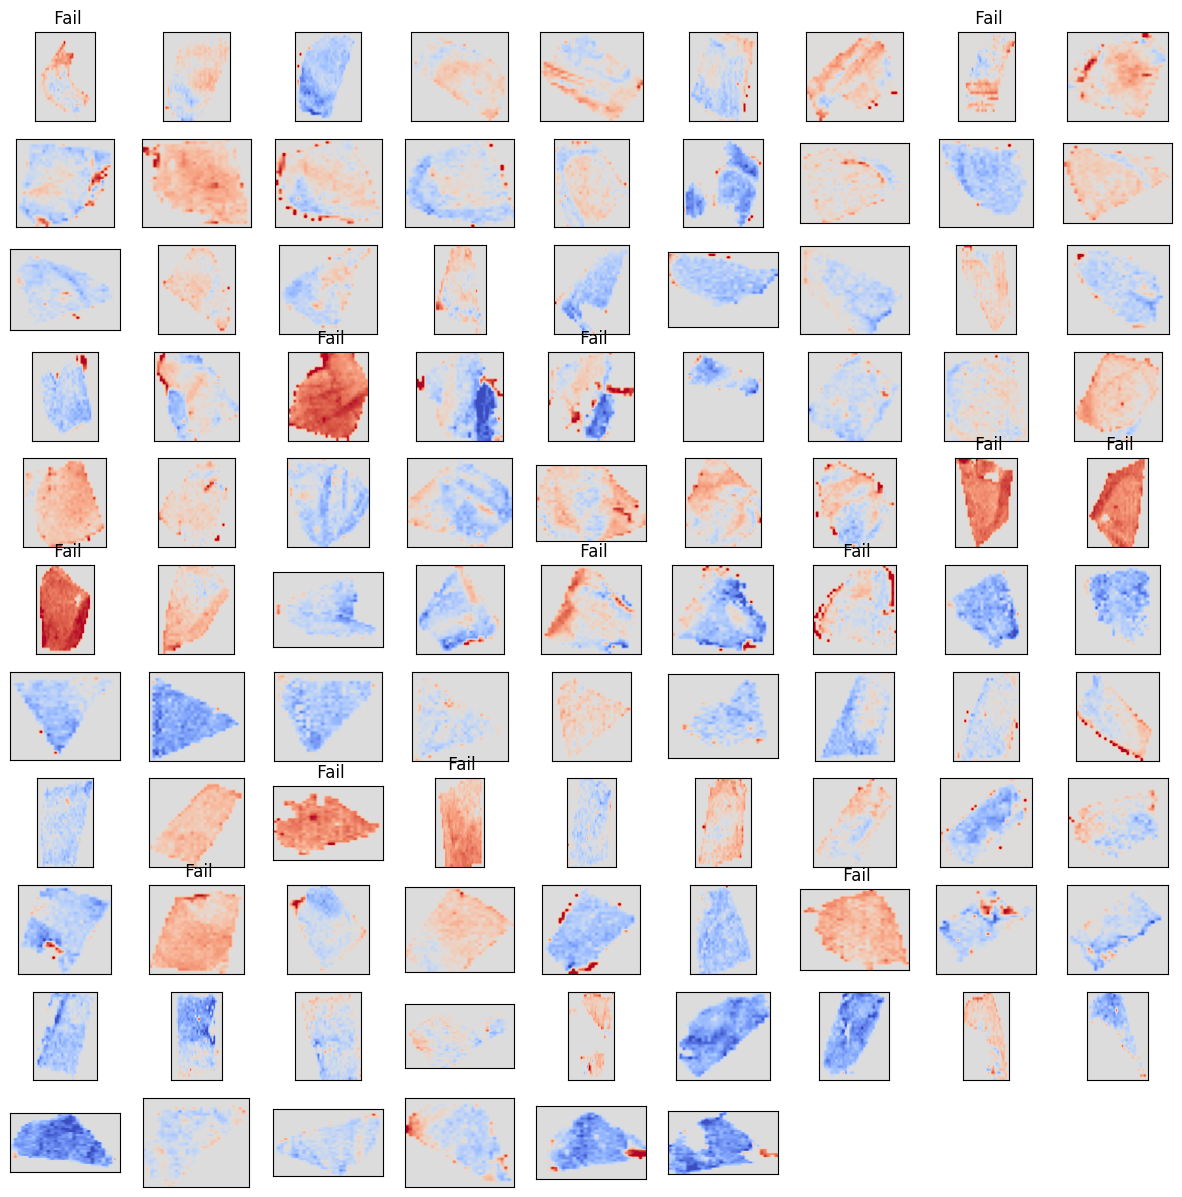

In [15]:
a = summarize_and_plot(mac_against_spatial)

# steps below can load RNASeq taxonomy to use as reference. 
needs to be tweaked to match the `Subclass_label` column in the RNAseq to the corresponding subclass label in the spatial data

In [6]:

mac_ref = ad.read_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/10x_seq/NHP_BG_AIT_116/AI_taxonomy.h5ad")

In [11]:
mac_ref

AnnData object with n_obs × n_vars = 135219 × 35219
    obs: 'sample_name_old', 'Class_id', 'Class_label', 'Class_color', 'Neighborhood_id', 'Neighborhood_label', 'Neighborhood_color', 'Subclass_id', 'Subclass_label', 'Subclass_color', 'Cluster_id', 'Cluster_label', 'Cluster_color', 'Donor_id', 'Donor_label', 'Donor_color', 'Load_id', 'Load_label', 'Load_color', 'Sex_id', 'Sex_label', 'Sex_color', 'Age_id', 'Age_label', 'Age_color', 'Species_id', 'Species_label', 'Species_color', 'Region_id', 'Region_label', 'Region_color', 'umi.counts_id', 'umi.counts_label', 'umi.counts_color', 'gene.counts.0_id', 'gene.counts.0_label', 'gene.counts.0_color', 'cluster_id', 'cluster_label', 'cluster_color', 'cluster', 'sample_id', 'off_target'
    var: 'gene', 'highly_variable_genes'
    uns: 'QC_markers', 'cellSet', 'clusterInfo', 'clustersUse', 'dend', 'filter', 'memb', 'mode', 'stats', 'taxonomyDir', 'taxonomyName'
    obsm: 'umap'
    layers: 'counts'

In [10]:
mac_ref.obs.columns

Index(['sample_name_old', 'Class_id', 'Class_label', 'Class_color',
       'Neighborhood_id', 'Neighborhood_label', 'Neighborhood_color',
       'Subclass_id', 'Subclass_label', 'Subclass_color', 'Cluster_id',
       'Cluster_label', 'Cluster_color', 'Donor_id', 'Donor_label',
       'Donor_color', 'Load_id', 'Load_label', 'Load_color', 'Sex_id',
       'Sex_label', 'Sex_color', 'Age_id', 'Age_label', 'Age_color',
       'Species_id', 'Species_label', 'Species_color', 'Region_id',
       'Region_label', 'Region_color', 'umi.counts_id', 'umi.counts_label',
       'umi.counts_color', 'gene.counts.0_id', 'gene.counts.0_label',
       'gene.counts.0_color', 'cluster_id', 'cluster_label', 'cluster_color',
       'cluster', 'sample_id', 'off_target'],
      dtype='object')

In [12]:
compare_reference_and_spatial(mac_ref,mac_ad, 
                                  category="Subclass_label", layer_field = "counts", 
                                  plot_stuff=True,
                                  target_obs_key = "n_transcripts", ok_to_clobber=True)


KeyError: 'Subclass_label'

In [ ]:
# loop over individual sections, comparing each to the whole dataset as reference
mac_against_spatial = {}
for ii,z in enumerate(sorted(list( mac_ad.obs.barcode.unique()))):

    s = spatial_detection_scores(mac_ad.obs,mac_ad[mac_ad.obs.barcode==z,:].obs, query_name=str(z), 
                                 category ='Subclass_Corr', n_bins=30, plot_stuff=False, comparison_column="n_transcripts")
    mac_against_spatial[z]=s

In [10]:
#potentially useful plotting stuff
fails_vs_all = []
min_cells_per_bin = 50
z_score_limit = -0.5
area_frac_limit = 0.1
plt.figure(figsize=[15,15])
for ii,z in enumerate(sorted(list(sds_against_all.keys()))):
    #estimate tissue bins:
    tissue_bins = sds_against_all[z]["count_image"]>min_cells_per_bin
    bad_frac = np.sum(sds_against_all[z]["z_score_image"][tissue_bins]<=z_score_limit)/np.sum(tissue_bins)
    plt.subplot(1+len(list(sds_against_all.keys()))//9,9, ii+1)
    image_to_show = sds_against_rnaseq[z]["z_score_image"].copy()
    image_to_show[np.logical_not(tissue_bins)]=0
    #ax = plt.imshow(image_to_show, vmin = -1, vmax=1, cmap = 'coolwarm_r')
    plt.hist(image_to_show[image_to_show!=0][:], bins = 30)
    plt.plot([z_score_limit,z_score_limit],[0,20],'r')
    plt.plot([0,0],[0,20],'b')

    plt.xlim([-2,2])
    #plt.imshow(sds_against_rnaseq[z]["z_score_image"], vmin = -1, vmax=1, cmap = 'coolwarm_r')
    if bad_frac>=area_frac_limit:
        fails_vs_all.append(z)
        plt.title("Fail", fontdict={"size":12})
    # else:
    #     plt.title("fail"), fontdict={"size":8})
    plt.xticks([])
    plt.yticks([])

print(len(fails_vs_all))

# plotting histograms of z_score next to z_score images for fails
fails = []
ii=0
for z in sorted(list(ad_sds_results.keys())):
    #estimate tissue bins:
    n_tissue_bins = np.sum(ad_sds_results[z]["difference_image"]!=0)
    bad_frac = np.sum(ad_sds_results[z]["z_score_image"]<=-.75)/n_tissue_bins
    plt.figure()
    plt.subplot(1,2,1)
    plt.hist(ad_sds_results[z]["z_score_image"].flat[ad_sds_results[z]["z_score_image"].flat!=0],cumulative=False, bins =50)
    plt.xlim([-1,1])
    plt.subplot(1,2,2)
    plt.imshow(ad_sds_results[z]["z_score_image"], vmin = -1, vmax=1, cmap = 'coolwarm_r')
    #plt.colorbar()
    plt.title( "   "+str(bad_frac)[:5]+" fail: "+str(bad_frac>=.1))
    # if bad_frac>=.1:
    #     fails.append(z)
    #     plt.subplot(1,2,1)
    #     plt.hist(ad_sds_results[z]["z_score_image"].flat,cumulative=True, bins =50)
    #     plt.xlim([-1,1])
    #     plt.subplot(1,2,2)
    #     plt.imshow(ad_sds_results[z]["z_score_image"], vmin = -1, vmax=1, cmap = 'coolwarm_r')
    #     plt.colorbar()
    #     plt.title( "   "+str(bad_frac)[:5]+" fail: "+str(bad_frac>=.1))

NameError: name 'ad_sds_results' is not defined

In [ ]:
# bunch 
#file:///programs/celltypes/workgroups/mousecelltypes/JackW/Merscope_OnDemand/serial%20sections/Xenium_20240918